In [1]:
import os
import re
import math
import copy
import pickle
import shutil
import warnings
import datetime
import numpy as np
import pandas as pd

In [2]:
import sys
sys.path.append("C:/Users/begas/Desktop/Project/Python/SmartFarm/5. SRC") # 다른 경로의 Class 불러올 때 사용
import common_preprocess_tools as prep
import model_tools             as mdl
import eval_tools              as evl

C:\Users\begas\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'

### 기본 셋팅하기

In [4]:
# -----------------------------------------------|
# ----- Step 1. Settings ------------------------
# -----------------------------------------------|
os.chdir("C:/Users/begas/Desktop/Project/Python/SmartFarm")
os.getcwd()

home_path  = os.getcwd()
data_path  = os.path.join(home_path,"1. DAT")
save_path  = os.path.join(home_path,"2. OUT")
model_path = os.path.join(home_path,"3. MODEL")

os.makedirs(data_path,exist_ok=True)
os.makedirs(save_path,exist_ok=True)
os.makedirs(model_path,exist_ok=True)

data_files = os.path.join(data_path,os.listdir(data_path)[-1])
print(data_files)

working_date = '20220926'

C:\Users\begas\Desktop\Project\Python\SmartFarm\1. DAT\샘플 데이터.csv


### 데이터 불러오기

In [5]:
'''
data_files  : Raw 데이터 위치
time_grp    : 시간대별 통계량 요약 기준 단위(ex : if time_grp = 60, then 60분 단위로 통계량 요약)
timr_window : 시차 (예측시간으로부터 window_v시간 전의 데이터를 설명변수로 사용)
'''
_prep = prep.common_preprocess(data_files = data_files, time_grp = 60, time_window = [12,24])

In [6]:
_prep.load_fn()

>> Raw 데이터 호출 및 단일값 컬럼 제거
모든 값이 NA인 변수 제거 : 거품도포시간/거품도포량


,시간,암모니아,황화수소,온도,습도,환기팬
0,2021-08-10 00:00:00,100.0,0.1,35.5,58,76
1,2021-08-10 00:00:00,100.0,0.1,35.5,58,75
2,2021-08-10 00:00:00,100.0,0.1,35.5,58,75
3,2021-08-10 00:00:00,100.0,0.1,35.5,58,75
4,2021-08-10 00:00:00,100.0,0.1,35.5,58,75
...,...,...,...,...,...,...
49140,2021-08-03 23:57:00,4.0,0.1,33.2,58,75
49141,2021-08-03 23:57:00,4.0,0.1,33.2,58,75
49142,2021-08-03 23:57:00,4.0,0.1,33.2,58,75
49143,2021-08-03 23:57:00,4.0,0.1,33.2,58,75


### 학습 데이터 전처리 하기

>> 이상치, 결측치 처리 및 시간대별 요약 통계량 생성
Step1. 이상치를 허용범위 내로 보정
Step2. 시간 변수를 60 분 단위로 변경
Step3. 시간별 요약통계량 데이터 생성
Step4. 특정 시간대의 데이터가 비어있을 시 해당 시간대 생성
- 0개의 시간대가 비어있습니다. 해당 시간대를 생성합니다.
Step5. 선형 보간법 적용


,시간,암모니아_mean,황화수소_mean,온도_mean,습도_mean,환기팬_mean,암모니아_min,황화수소_min,온도_min,습도_min,...,암모니아_max,황화수소_max,온도_max,습도_max,환기팬_max,암모니아_std,황화수소_std,온도_std,습도_std,환기팬_std
0,2021-08-03 10:00:00,2.500000,0.1,32.546610,56.508475,75.016949,2.5,0.1,32.4,56.0,...,2.5,0.1,32.7,58.0,76.0,0.000000,2.229915e-16,0.147157,0.535026,0.129631
1,2021-08-03 11:00:00,16.248744,0.1,31.021106,67.577889,75.135678,4.0,0.1,30.7,66.0,...,24.0,0.1,31.5,69.0,86.0,7.290660,5.565115e-17,0.198878,0.747192,0.977878
2,2021-08-03 12:00:00,4.728814,0.1,31.962288,64.508475,75.033898,4.0,0.1,30.4,61.0,...,10.5,0.1,32.9,69.0,83.0,1.152507,2.781457e-16,0.950150,2.955689,0.520756
3,2021-08-03 13:00:00,5.588983,0.1,33.404661,59.504237,75.004237,4.0,0.1,33.1,58.0,...,11.5,0.1,33.7,61.0,76.0,1.939106,2.781457e-16,0.171909,1.116598,0.065094
4,2021-08-03 14:00:00,4.040254,0.1,34.039831,57.466102,75.021186,4.0,0.1,33.8,57.0,...,6.0,0.1,34.3,58.0,79.0,0.229408,2.781457e-16,0.184340,0.499910,0.268122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,2021-08-10 09:00:00,93.894558,0.1,34.612585,59.469388,75.013605,22.0,0.1,34.5,59.0,...,100.0,0.1,34.7,60.0,78.0,12.142531,5.004522e-16,0.048296,0.499913,0.184239
168,2021-08-10 10:00:00,95.625850,0.1,34.742177,59.670068,75.003401,20.5,0.1,34.6,59.0,...,100.0,0.1,34.9,60.0,76.0,11.131366,5.004522e-16,0.111720,0.470990,0.058321
169,2021-08-10 11:00:00,93.180272,0.1,35.014286,59.880952,75.010204,22.0,0.1,34.8,59.0,...,100.0,0.1,35.2,60.0,76.0,11.596743,5.004522e-16,0.081789,0.324397,0.100670
170,2021-08-10 12:00:00,97.015254,0.1,35.299322,59.427119,75.010169,22.5,0.1,35.1,58.0,...,100.0,0.1,35.5,60.0,76.0,10.751077,5.004493e-16,0.108795,0.509044,0.100500


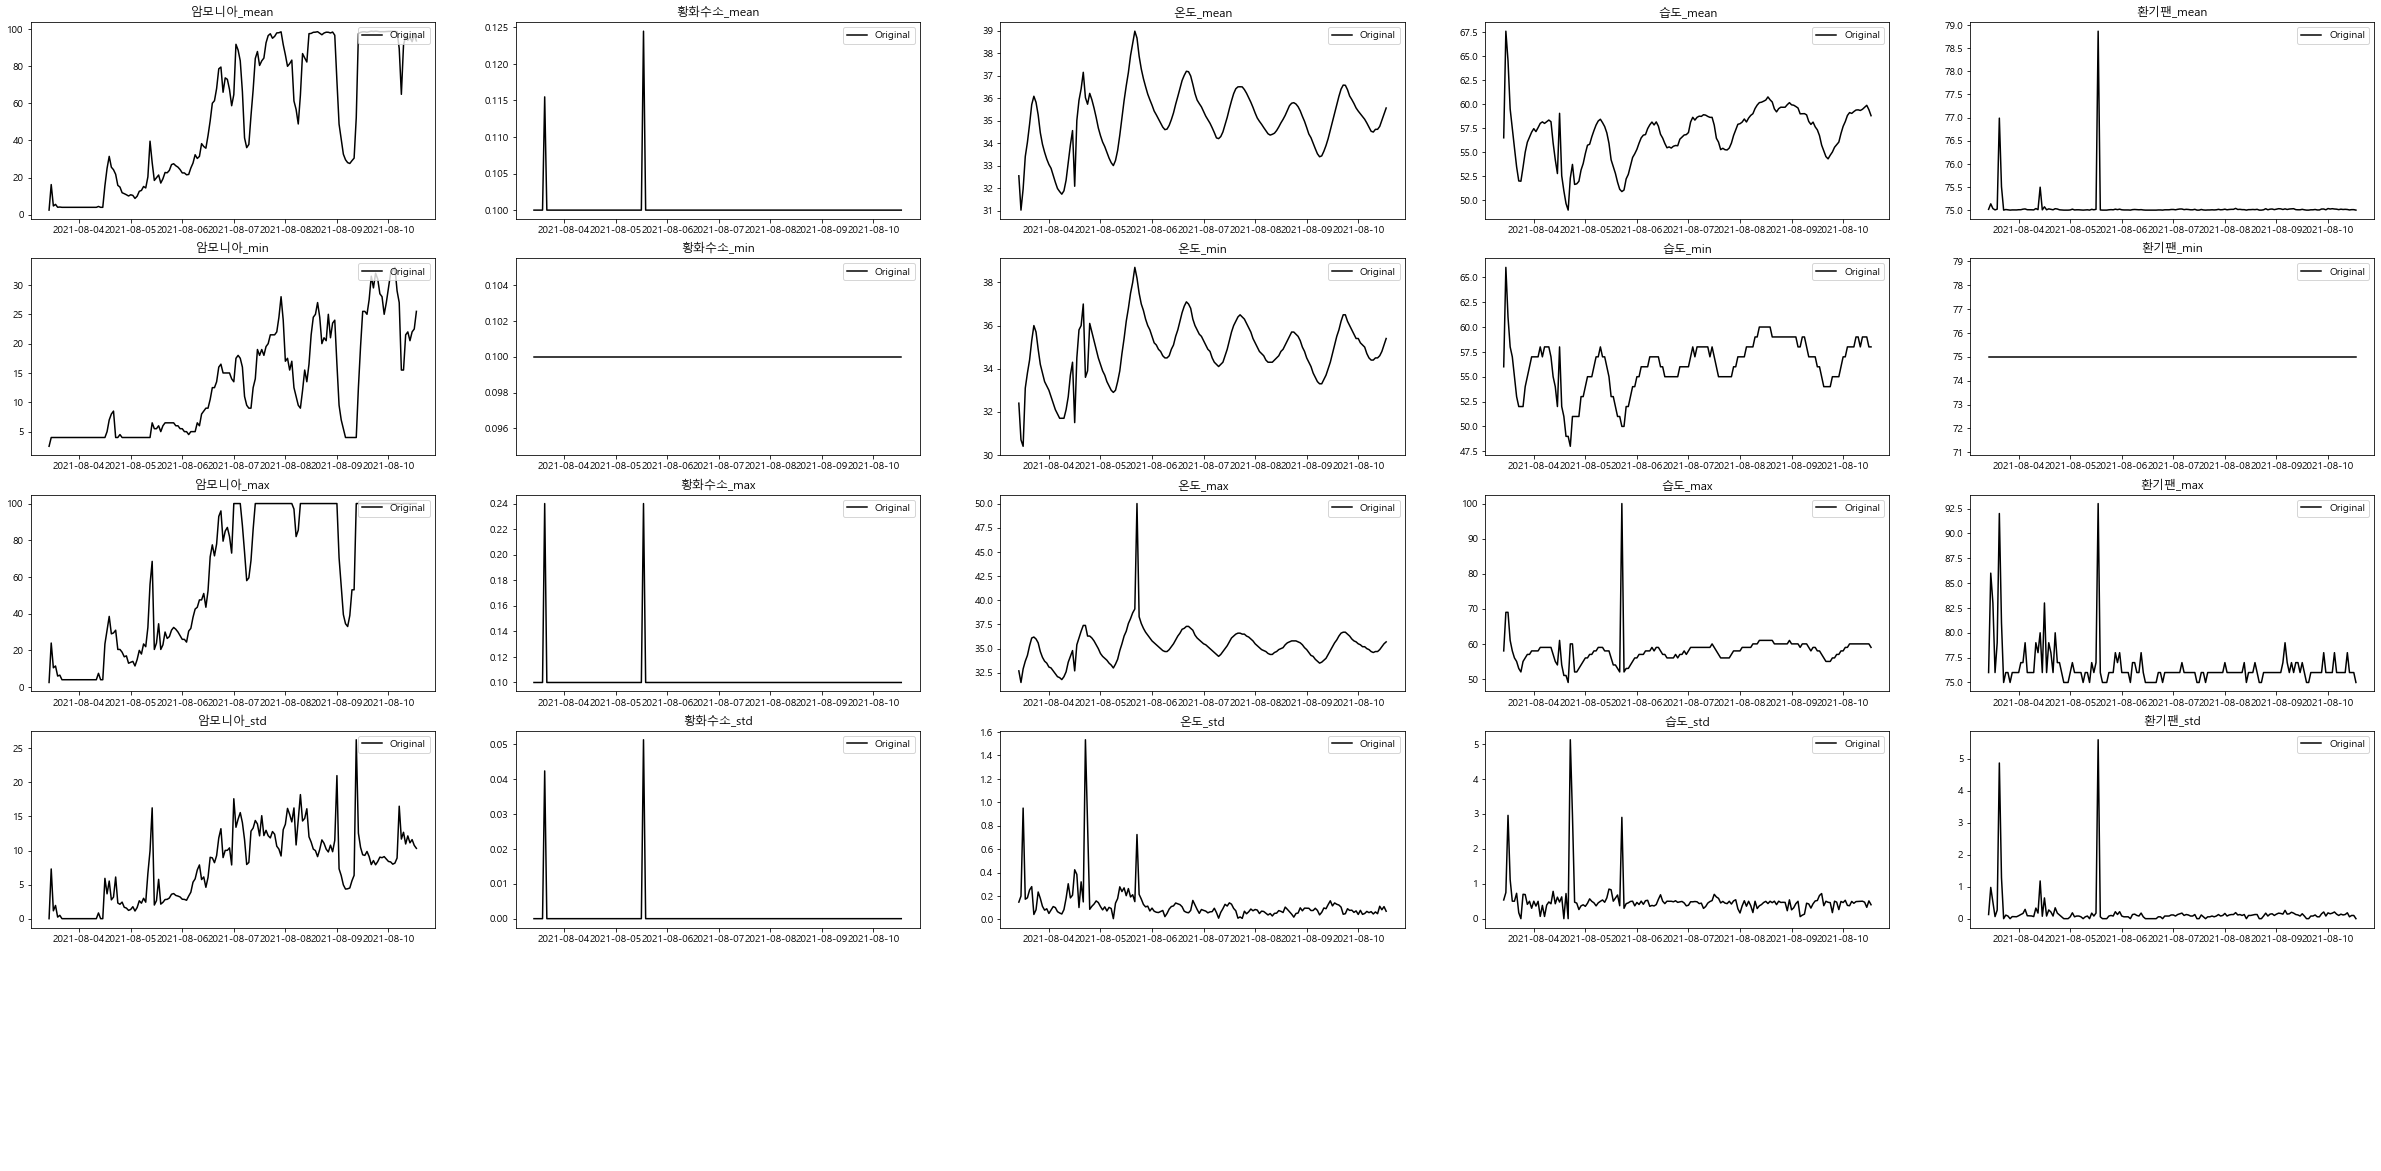

In [7]:
_prep.preprocess_fn()

### 학습 - 분석용 데이터 생성

In [8]:
_prep.train_anal_dat_fn()

>> 학습 - 분석용 데이터 생성[종속, 설명(시차변수) 생성]
Step1. 목표변수: 암모니아, 황화수소 단위별 max 값
Step2. 시차 변수 생성
Step3. 학습/검증 데이터 7:3으로 분할
Step4. 단일 값만 가지는 설명변수 제거


{'train_dat':            predict_time  y_암모니아  y_황화수소           base_time  x_암모니아_mean_12  \
 0   2021-08-04 10:00:00     4.0     0.1 2021-08-03 10:00:00        4.000000   
 1   2021-08-04 11:00:00     4.0     0.1 2021-08-03 11:00:00        4.000000   
 2   2021-08-04 12:00:00    23.5     0.1 2021-08-03 12:00:00        4.000000   
 3   2021-08-04 13:00:00    31.0     0.1 2021-08-03 13:00:00        4.000000   
 4   2021-08-04 14:00:00    38.5     0.1 2021-08-03 14:00:00        4.000000   
 ..                  ...     ...     ...                 ...             ...   
 99  2021-08-08 13:00:00   100.0     0.1 2021-08-07 13:00:00       79.908163   
 100 2021-08-08 14:00:00   100.0     0.1 2021-08-07 14:00:00       81.337288   
 101 2021-08-08 15:00:00   100.0     0.1 2021-08-07 15:00:00       83.247458   
 102 2021-08-08 16:00:00   100.0     0.1 2021-08-07 16:00:00       61.222034   
 103 2021-08-08 17:00:00   100.0     0.1 2021-08-07 17:00:00       56.710169   
 
      x_황화수소_mean_12  x_온

### 모델링

In [9]:
for y_name in ['y_암모니아','y_황화수소']:
    print(f'> {y_name} Modeling Start')
    
    # 모델링
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        _model = mdl.model(y_name,_prep.train_anal_dat)
        
    # 모델 평가    
    eval_result = evl.eval(_model.__dict__).eval_res
    model_root_dir = os.path.join(model_path,working_date,y_name)
    shutil.rmtree(model_root_dir,ignore_errors=True)
    os.makedirs(model_root_dir, exist_ok=True)
    eval_result.to_pickle(os.path.join(model_root_dir,'eval_result.pkl'))   
    
    # Best 모델 저장
    best_model = eval_result.iloc[0]['model']
    # best_model = 'LSTM'
    shutil.rmtree(os.path.join(model_root_dir,'BEST'),ignore_errors=True)
    os.makedirs(os.path.join(model_root_dir,'BEST'), exist_ok=True)
    
    if best_model in ['ANN','LSTM'] :
        # 모델 패스 설정
        mdl_path_name = os.path.join(model_root_dir,'BEST',best_model + '.h5')
        
        # 모델 저장
        _model.__dict__[best_model.lower() + '_ret']['model'].save(mdl_path_name)
        
        # 모델 관련 정보 저장
        _model.__dict__[best_model.lower() + '_ret']['model'] = mdl_path_name
        with open(os.path.join(model_root_dir,'BEST',best_model + '_info.pkl'),'wb') as fw:
                    pickle.dump( _model.__dict__[best_model.lower() + '_ret'], fw)
    else :
        # 모델 패스 설정
        mdl_path_name = os.path.join(model_root_dir,'BEST',best_model + '.pkl')
        
        # 모델 저장
        with open(os.path.join(model_root_dir,'BEST',best_model + '.pkl'),'wb') as fw:
            pickle.dump(_model.__dict__[best_model.lower() + '_ret']['model'], fw)
            
       # 모델 관련 정보 저장
        _model.__dict__[best_model.lower() + '_ret']['model'] = mdl_path_name
        with open(os.path.join(model_root_dir,'BEST',best_model + '_info.pkl'),'wb') as fw:
                    pickle.dump( _model.__dict__[best_model.lower() + '_ret'], fw)    

> y_암모니아 Modeling Start
           Model Type is MLR            
튜닝 및 학습에 소요된 시간 : 0:00:00
      Model Type is Random Forest       
INFO:tensorflow:Oracle triggered exit
{'n_estimators': 30, 'max_depth': 4}
튜닝 및 학습에 소요된 시간 : 0:00:04
          Model Type is ARIMA           
튜닝 및 학습에 소요된 시간 : 0:00:09
         Model Type is XGBoost          
INFO:tensorflow:Oracle triggered exit
{'n_estimators': 50, 'max_depth': 3, 'min_child_weight': 1.2}
튜닝 및 학습에 소요된 시간 : 0:00:06
         Model Type is LightGBM         
INFO:tensorflow:Oracle triggered exit
{'n_estimators': 120, 'max_depth': 7, 'num_leaves': 34}
튜닝 및 학습에 소요된 시간 : 0:00:01
           Model Type is ANN            
 Tuning Method : Bayesian Optimization  
Tuner Search Try - 00
Tuner Search Try - 01
INFO:tensorflow:Oracle triggered exit
{'num_layers': 3, 'units_1': 32, 'lr': 0.01, 'units_2': 32, 'units_3': 32}
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape         

 lstm_layer_3 (LSTM)         (None, 5, 32)             8320      
                                                                 
 output_layer (Dense)        (None, 5, 1)              33        
                                                                 
Total params: 24,993
Trainable params: 24,993
Non-trainable params: 0
_________________________________________________________________
Restoring model weights from the end of the best epoch: 19.
Epoch 29: early stopping
튜닝 및 학습에 소요된 시간 : 0:03:29
> MLR  / MAPE : 0.0828 / ACC :  1.0000
> RF   / MAPE : 0.0013 / ACC :  1.0000
> ARIMA / MAPE : 0.0828 / ACC :  1.0000
> XGB  / MAPE : 0.0008 / ACC :  1.0000
> LGB  / MAPE : 0.0105 / ACC :  1.0000
> ANN  / MAPE : 0.0090 / ACC :  1.0000
> LSTM / MAPE : 0.0151 / ACC :  1.0000
BEST Model is XGB  / MAPE :  0.0008 / ACC :  1.0000
